### Init

In [8]:
import os

# Project settings
project_path = os.getcwd()

# ImageNet settings
image_size = 224 # '224', '192', '160', or '128' px
mobilenet_version = '0.50' # versions possible: '1.0', '0.75', '0.50'
architecture = f'mobilenet_{mobilenet_version}_{image_size}'
iterations = 4000

### Prepare images

In [15]:
%%bash -s "$project_path"
cd $1/tf_files
curl -O http://download.tensorflow.org/example_images/flower_photos.tgz
tar xzf flower_photos.tgz 
rm flower_photos.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  12.1M      0  0:00:17  0:00:17 --:--:-- 11.6M


### Start tensorboard
`tensorboard --logdir tf_files/training_summaries &`
  
If board is already running:  
`pkill -f "tensorboard"`

### Retrain model

In [16]:
%%bash -s "$architecture" "$iterations"
python3 -m scripts.retrain \
  --bottleneck_dir=tf_files/bottlenecks \
  --how_many_training_steps=$2 \
  --model_dir=tf_files/models/ \
  --summaries_dir=tf_files/training_summaries/$1 \
  --output_graph=tf_trained/retrained_graph.pb \
  --output_labels=tf_trained/retrained_labels.txt \
  --architecture="$1" \
  --image_dir=tf_files/flower_photos

Converted 2 variables to const ops.


INFO:tensorflow:Looking for images in 'roses'
INFO:tensorflow:Looking for images in 'sunflowers'
INFO:tensorflow:Looking for images in 'daisy'
INFO:tensorflow:Looking for images in 'dandelion'
INFO:tensorflow:Looking for images in 'tulips'
2017-11-25 01:19:04.385130: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-25 01:19:04.385153: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-11-25 01:19:04.385158: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-25 01:19:04.385165: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlo

### Quantitize graph

In [17]:
%%bash
python3 -m scripts.quantize_graph \
  --input=tf_trained/retrained_graph.pb \
  --output=tf_trained/rounded_graph.pb \
  --output_node_names=final_result \
  --mode=weights_rounded

### Use model

In [18]:
image_url = 'tf_files/flower_photos/roses/2414954629_3708a1a04d.jpg'

In [22]:
%%bash -s "$image_size" "$image_url"
python3 -m scripts.label_image \
    --input_height $1 \
    --input_width $1 \
    --graph=tf_trained/rounded_graph.pb \
    --labels=tf_trained/retrained_labels.txt \
    --image=$2


Evaluation time (1-image): 0.283s

tulips 0.539964
roses 0.460035
daisy 3.78459e-07
dandelion 2.63948e-08
sunflowers 8.10065e-09


2017-11-25 01:27:46.642796: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-25 01:27:46.642822: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-11-25 01:27:46.642827: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-25 01:27:46.642831: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.


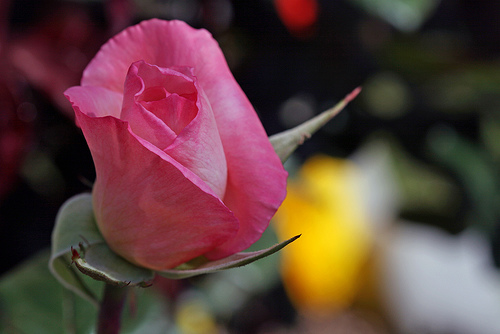

In [23]:
from IPython.display import Image
url = f'{project_path}/{image_url}'
Image(url,width=300, height=300)